# CIFAR-10 Dataset

## Setup

In [1]:
!wget -q https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ./data/cifar-10-python.tar.gz

In [3]:
!tar -xzf ./data/cifar-10-python.tar.gz --directory ./data

In [2]:
#using loader provided by snatch59 on github: https://github.com/snatch59/load-cifar-10
!wget -q https://raw.githubusercontent.com/snatch59/load-cifar-10/master/load_cifar_10.py -O load_cifar_10.py

In [2]:
import load_cifar_10

import cv2

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

import models

from sift import change_descriptors_to_float
from sift import compute_descriptor_list_from_numpy_arrays
from sift import compute_image_features
from sift import compute_vocabulary
from sift import unwrap_descriptor_list

import sklearn.metrics as metrics

import time

In [3]:
cifar_train_data, \
    cifar_train_filenames, \
    cifar_train_labels, \
    cifar_test_data, \
    cifar_test_filenames, \
    cifar_test_labels, \
    cifar_label_names = load_cifar_10.load_cifar_10_data("./data/cifar-10-batches-py")
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

horse


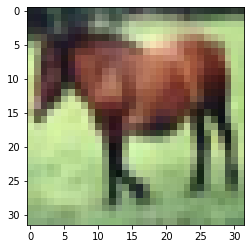

In [4]:
im = Image.fromarray(cifar_train_data[7])
plt.imshow(im)
print(labels[cifar_train_labels[7]])

## Simple feature extraction

In [8]:
# All this is stolen from TUWEL

def histogram_feature_extraction_easy(image_data):
    data = []
    for index, image in enumerate(image_data):
        imagePIL = Image.fromarray(image)
        imagePIL = imagePIL.convert('RGB')     
        featureVector=imagePIL.histogram()
        
        if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
            print("Unexpected length of feature vector: {} in image with index: {}".format(str(len(featureVector)), index))

        data.append((featureVector))
    return data

def histogram_feature_extraction_open_cv(image_data):
    dataOpenCV_1D=[]
    dataOpenCV_2D=[]
    dataOpenCV_3D=[]

    flatten = lambda l: [item for sublist in l for item in sublist]

    for index, image in enumerate(image_data):
        imagePIL = Image.fromarray(image)
        imagePIL = imagePIL.convert('RGB')
        imageOpenCV = np.array(imagePIL) 
        # Convert RGB to BGR 
        imageOpenCV = imageOpenCV[:, :, ::-1].copy() 

        # Now we split the image in the three channels, B / G / R
        chans = cv2.split(imageOpenCV)
        colors = ("b", "g", "r")

        # First we do also features per channel, but this time, we aggregate them into a smaller number of bins
        # I.e. we do not have 256 values per channel, but less
        featuresOpenCV_1D = []
        bins_1D=64
        for (chan, color) in zip(chans, colors): # we compute the histogram over each channel
            histOpenCV = cv2.calcHist([chan], [0], None, [bins_1D], [0, 256])
            featuresOpenCV_1D.extend(histOpenCV)
        featureVectorOpenCV_1D = flatten(featuresOpenCV_1D) # and append this to our feature vector
        
        dataOpenCV_1D.append(featureVectorOpenCV_1D) # now we append the feature vector to the dataset so far

        if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
            print("Unexpected length of feature vector: {} with index: {}".format(str(len(featureVectorOpenCV_1D)), index))

        # Next - features that look at two channels at the same time
        # E.g. we look at when green and blue have both "high values"
        # We reduce the size of bins further, to not have a too long feature vector
        featuresOpenCV_2D = []
        bins2D=16
        # look at all combinations of channels (R & B, R & G, B & G)
        featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[0]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
        featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
        featuresOpenCV_2D.extend(cv2.calcHist([chans[0], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
        # and add that to our dataset
        featureVectorOpenCV_2D = flatten(featuresOpenCV_2D)
        dataOpenCV_2D.append(featureVectorOpenCV_2D)

        # finally, we look at all three channels at the same time.
        # We further reduce our bin size, because otherwise, this would become very large...
        featuresOpenCV_3D = cv2.calcHist([imageOpenCV], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        # append to our dataset
        featureVectorOpenCV_3D = featuresOpenCV_3D.flatten()
        dataOpenCV_3D.append(featureVectorOpenCV_3D)

    return dataOpenCV_1D, dataOpenCV_2D, dataOpenCV_3D
    

In [9]:
train_easy = histogram_feature_extraction_easy(cifar_train_data)
train_dataOpenCV_1D, train_dataOpenCV_2D, train_dataOpenCV_3D = histogram_feature_extraction_open_cv(cifar_train_data)

In [10]:
test_easy = histogram_feature_extraction_easy(cifar_test_data)
test_dataOpenCV_1D, test_dataOpenCV_2D, test_dataOpenCV_3D = histogram_feature_extraction_open_cv(cifar_test_data)

In [11]:
data_sets = [
    (train_easy, test_easy, "./results/cifar_10_easy_{}", "Easy"),
    (train_dataOpenCV_1D, test_dataOpenCV_1D, "./results/cifar_10_opencv_1D_{}", "OpenCV 1D"),
    (train_dataOpenCV_2D, test_dataOpenCV_2D, "./results/cifar_10_opencv_2D_{}", "OpenCV 2D"),
    (train_dataOpenCV_3D, test_dataOpenCV_3D, "./results/cifar_10_opencv_3D_{}", "OpenCV 3D")
]

models_array = [
    (models.do_logistic_regression, "logistic_regression", "Logistic Regression"),
    (models.do_lda, "lda", "LDA"),
    (models.do_svm, "svm", "SVM"),
    (models.do_mlp, "mlp", "MLP")
]

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification report for SVM
Accuracy score: 0.2819
Recall score: 0.2819
Precision score: 0.27576898405264216
F1-Score score: 0.2727598898304672


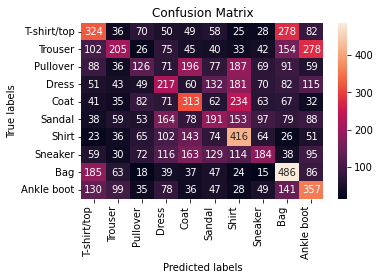

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification report for SVM
Accuracy score: 0.2993
Recall score: 0.2993
Precision score: 0.292277383597951
F1-Score score: 0.2886635113966363


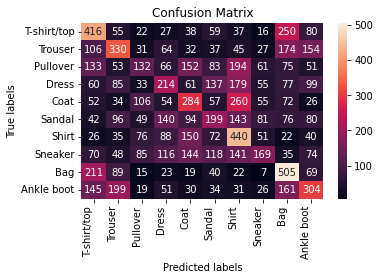

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification report for MLP
Accuracy score: 0.2741
Recall score: 0.2741
Precision score: 0.275285152194262
F1-Score score: 0.2683012450918858


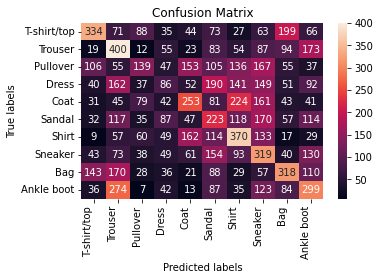

Classification report for MLP
Accuracy score: 0.3114
Recall score: 0.3114
Precision score: 0.30790960234763215
F1-Score score: 0.29137955199480664


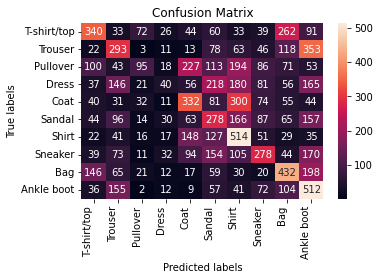

Classification report for MLP
Accuracy score: 0.3357
Recall score: 0.3357
Precision score: 0.3386235814703908
F1-Score score: 0.33266932724297865


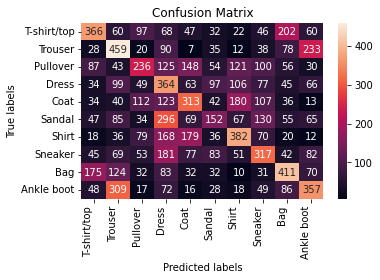

C:\Users\Paul\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification report for MLP
Accuracy score: 0.3887
Recall score: 0.3887
Precision score: 0.3886010320773598
F1-Score score: 0.38479781139262403


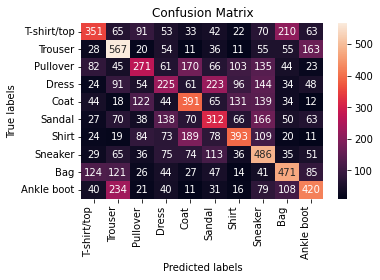

In [24]:
i = 10
for (model_method, simple_name, full_name) in models_array:
    for (train, test, path, name) in data_sets:
        if i > 0:
            i = i - 1
            continue
        model_method(train, cifar_train_labels, test, cifar_test_labels, labels, path.format(simple_name) + "_{}")

In [12]:
results = []
for (model_method, simple_name, full_name) in models_array:
    for (train, test, path, data_set_name) in data_sets:
        df_preds = pd.read_csv(path.format(simple_name) + "_test_set_predictions.csv")
        results.append([
            "{} - {}".format(full_name, data_set_name),
            metrics.accuracy_score(df_preds["y_true"], df_preds["y_pred"]),
            metrics.recall_score(df_preds["y_true"], df_preds["y_pred"], average="weighted"),
            metrics.precision_score(df_preds["y_true"], df_preds["y_pred"], average="weighted"),
            metrics.f1_score(df_preds["y_true"], df_preds["y_pred"], average="weighted")
        ])
df_results = pd.DataFrame(data=results, columns=["Name", "Accuracy", "Recall", "Precision", "F1"])

Classification report for Logistic Regression - Easy
Accuracy score: 0.242
Recall score: 0.242
Precision score: 0.23346884918631478
F1-Score score: 0.23504654835167849


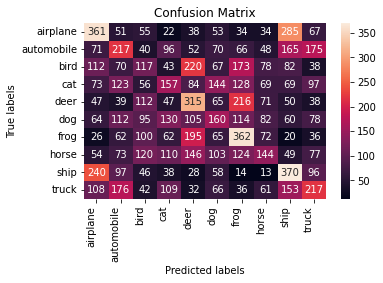

Classification report for Logistic Regression - OpenCV 1D
Accuracy score: 0.2687
Recall score: 0.2687
Precision score: 0.25982791633141317
F1-Score score: 0.25884440372173323


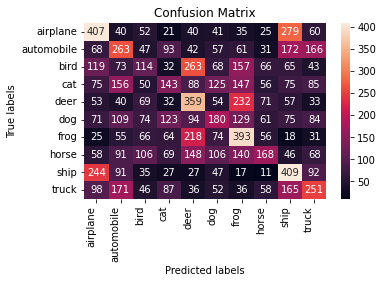

Classification report for Logistic Regression - OpenCV 2D
Accuracy score: 0.3188
Recall score: 0.3188
Precision score: 0.3131588882371475
F1-Score score: 0.31319838033021863


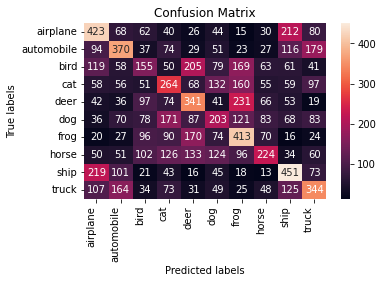

Classification report for Logistic Regression - OpenCV 3D
Accuracy score: 0.3183
Recall score: 0.3183
Precision score: 0.31209831352995365
F1-Score score: 0.3120972016372793


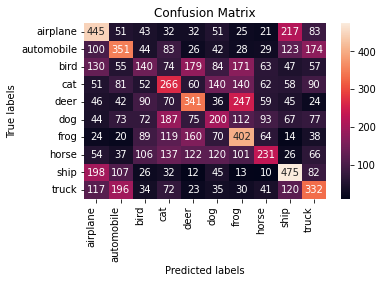

Classification report for LDA - Easy
Accuracy score: 0.2426
Recall score: 0.2426
Precision score: 0.23298492247977826
F1-Score score: 0.23501185726909263


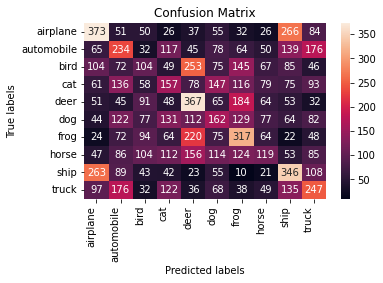

Classification report for LDA - OpenCV 1D
Accuracy score: 0.2615
Recall score: 0.2615
Precision score: 0.25166290040967165
F1-Score score: 0.2512709519333484


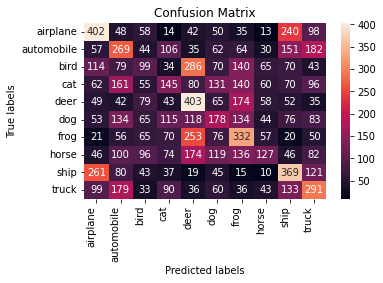

Classification report for LDA - OpenCV 2D
Accuracy score: 0.3071
Recall score: 0.3071
Precision score: 0.3028002427888658
F1-Score score: 0.3018527958469187


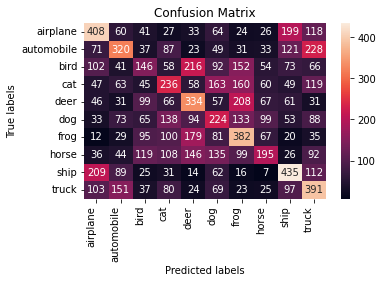

Classification report for LDA - OpenCV 3D
Accuracy score: 0.301
Recall score: 0.301
Precision score: 0.298115346168436
F1-Score score: 0.29601200432119756


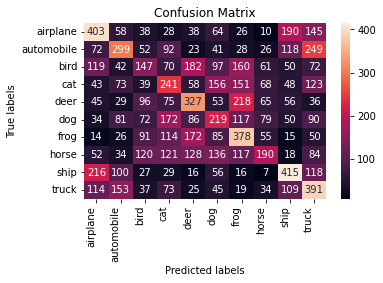

Classification report for SVM - Easy
Accuracy score: 0.1956
Recall score: 0.1956
Precision score: 0.18684464308144022
F1-Score score: 0.18495592646309647


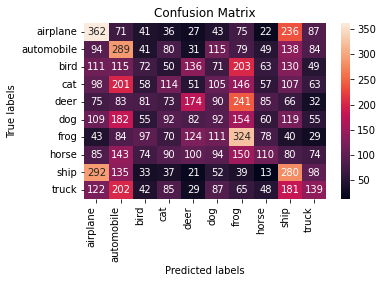

Classification report for SVM - OpenCV 1D
Accuracy score: 0.2493
Recall score: 0.2493
Precision score: 0.23560881535412387
F1-Score score: 0.22623327615871594


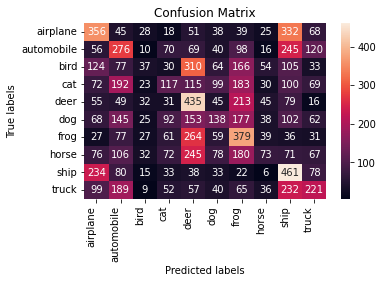

Classification report for SVM - OpenCV 2D
Accuracy score: 0.2819
Recall score: 0.2819
Precision score: 0.27576898405264216
F1-Score score: 0.2727598898304672


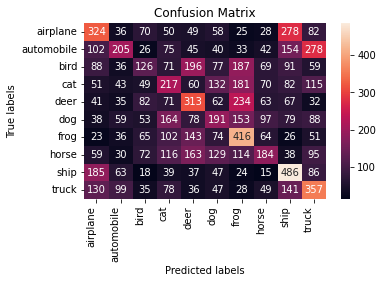

Classification report for SVM - OpenCV 3D
Accuracy score: 0.2993
Recall score: 0.2993
Precision score: 0.292277383597951
F1-Score score: 0.2886635113966363


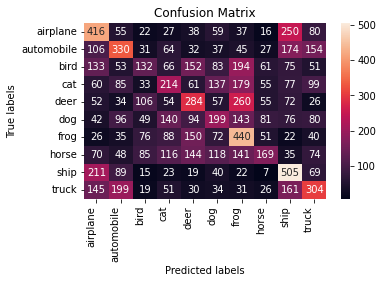

Classification report for MLP - Easy
Accuracy score: 0.2741
Recall score: 0.2741
Precision score: 0.275285152194262
F1-Score score: 0.2683012450918858


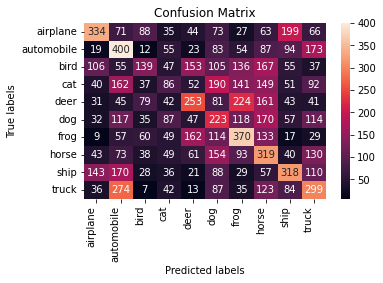

Classification report for MLP - OpenCV 1D
Accuracy score: 0.3114
Recall score: 0.3114
Precision score: 0.30790960234763215
F1-Score score: 0.29137955199480664


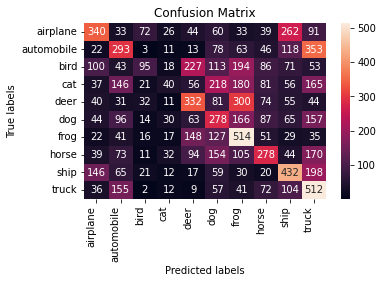

Classification report for MLP - OpenCV 2D
Accuracy score: 0.3357
Recall score: 0.3357
Precision score: 0.3386235814703908
F1-Score score: 0.33266932724297865


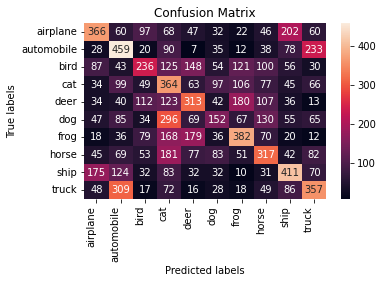

Classification report for MLP - OpenCV 3D
Accuracy score: 0.3887
Recall score: 0.3887
Precision score: 0.3886010320773598
F1-Score score: 0.38479781139262403


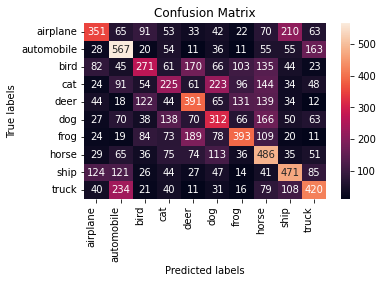

In [13]:
for (model_method, simple_name, full_name) in models_array:
    for (train, test, path, data_set_name) in data_sets:
        df_preds = pd.read_csv(path.format(simple_name) + "_test_set_predictions.csv")
        models.do_classification_report(df_preds["y_true"], df_preds["y_pred"], "{} - {}".format(full_name, data_set_name), labels, path.format(simple_name) + "_{}")

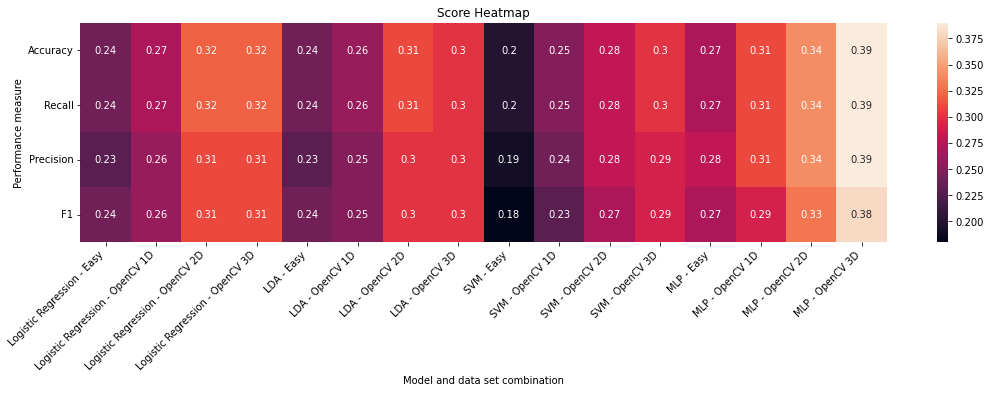

In [45]:
import seaborn as sns

plt.figure(figsize=(20,5))
ax= plt.subplot()
scores = []
names = []
for label, content in df_results.iteritems():
    if label == "Name":
        names = content.array
    else:
        rounded = list(map(lambda f: round(f, 2), content.array))
        scores.append(rounded)

sns.heatmap(scores, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Model and data set combination')
ax.set_ylabel('Performance measure') 
ax.set_title('Score Heatmap')
ax.xaxis.set_ticklabels(names)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
ax.yaxis.set_ticklabels(["Accuracy", "Recall", "Precision", "F1"])

plt.gcf().subplots_adjust(left=0.2, bottom=0.27)

## SIFT and Visual Bag of Words

In [5]:
def convert_to_grayscale_arrays(images):
  grayscale_images = []
  for image in images:
      image_pillow = Image.fromarray(image)
      pixels = get_grayscale_pixels(image_pillow)
      grayscale_images.append(pixels)
  return grayscale_images

def get_grayscale_pixels(image):
  pix = []
  width, height = image.size
  for i in range(0, width):
    for j in range(0, height):
      pix.append(image.getpixel((i,j)))
  return np.array(pix)

In [7]:
example = Image.fromarray(cifar_train_data[0])
get_grayscale_pixels(example)

array([[ 59,  62,  63],
       [ 16,  20,  20],
       [ 25,  24,  21],
       ...,
       [ 53,  34,  20],
       [ 83,  53,  34],
       [123,  92,  72]])

In [4]:
start_time = time.time()

train_descriptor_list = compute_descriptor_list_from_numpy_arrays(cifar_train_data)
train_unwrapped_descriptor_list = unwrap_descriptor_list(train_descriptor_list)
train_descriptor_list_float = change_descriptors_to_float(train_unwrapped_descriptor_list)
vocabulary = compute_vocabulary(train_descriptor_list_float)
train_image_features = compute_image_features(train_descriptor_list, vocabulary)

print("Execution took {} seconds.".format(time.time() - start_time))

df_train_image_features = pd.DataFrame(data=train_image_features)
df_train_image_features.to_csv("saves/cifar_10_sift_train.csv", index=False)

Computing descriptors...


TypeError: Can't convert object to 'str' for 'filename'

In [ ]:
start_time = time.time()

test_descriptor_list = compute_descriptor_list_from_numpy_arrays(cifar_test_data)
test_unwrapped_descriptor_list = unwrap_descriptor_list(test_descriptor_list)
test_descriptor_list_float = change_descriptors_to_float(test_unwrapped_descriptor_list)
vocabulary = compute_vocabulary(test_descriptor_list_float)
test_image_features = compute_image_features(test_descriptor_list, vocabulary)

print("Execution took {} seconds.".format(time.time() - start_time))

df_test_image_features = pd.DataFrame(data=test_image_features)
df_test_image_features.to_csv("saves/cifar_10_sift_test.csv", index=False)

In [3]:
df_train_image_features = pd.read_csv("saves/cifar_10_sift_train.csv")
df_test_image_features = pd.read_csv("saves/cifar_10_sift_test.csv")

NameError: name 'pd' is not defined

In [ ]:
for (model_method, simple_name, full_name) in models_array:
    model_method(df_train_image_features, cifar_train_labels, df_test_image_features, cifar_test_labels, labels, "./results/cifar_10_sift_"+simple_name+"_{}")